# 1.  Formulating our objective.
**AIM** to **classify the images of X-rays** to **identify** which show signs of **pneumonia**. It is a **binary classification**.

# 2. import library

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# 3. Reading Data
Data is in chest-xray-pneumonia/chest_xray/ and divided to train, val and test. 

In [2]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 5
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


[# 4. visualization of Data
visualization of the contribution of each class](http://)

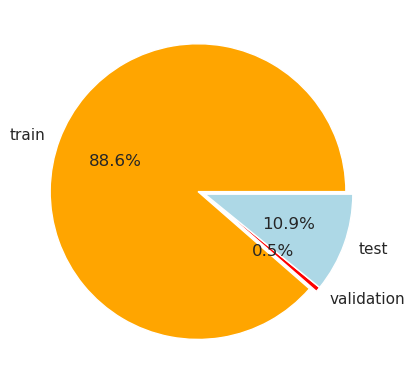

In [3]:
plt.pie([len(train), len(validation), len(test)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.show()

In [4]:
print(train.class_names)
print(validation.class_names)
print(test.class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


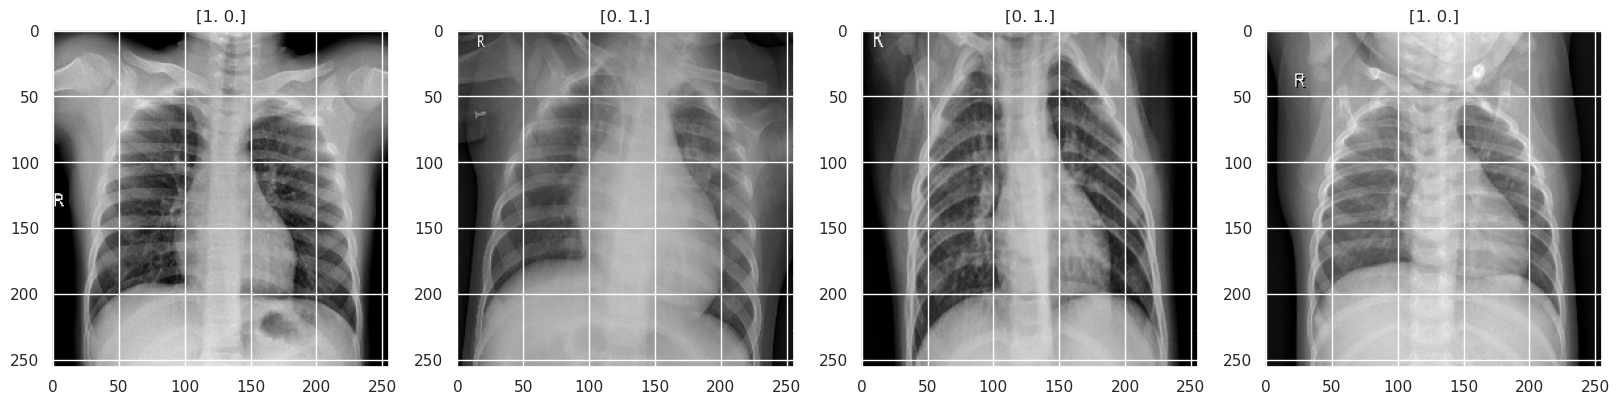

In [5]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 5. Extracting Features and Labels


In [7]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

# Concatenate the lists to get the full 'x' and 'y' arrays
x_train = np.concatenate(x_train, axis=0)
x_val = np.concatenate(x_val, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_test = np.concatenate(y_test, axis=0)



# Optionally, you can check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train':", y_train.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train': (5216, 2)


# 6. Normalization of Training, Validation, and Test Data

In [8]:
x_train=x_train/256
x_val=x_val/256
x_test=x_test/256

# 7. Train a Model
We use transfer learning with VGG16 as the base model.

In [11]:
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    
    return CNN

# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_4 (Dropout)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18,909,378
Trainable params: 11,274,114


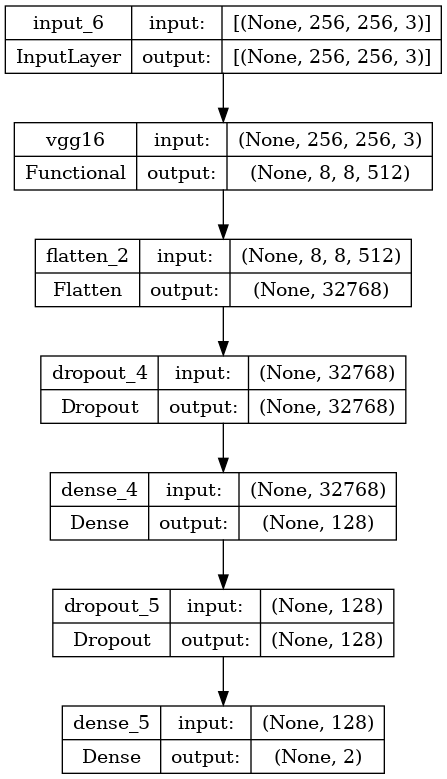

In [12]:
# Visualized Layers of CNN
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
hist = model.fit(x_train, y_train, epochs= epochs, validation_data= (x_val, y_val))
print(hist.history)
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")


# 8. Evaluate the model

In [ ]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Classification Report
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)
     
print(f"Precision: {pre.result().numpy()} , Recall: {re.result().numpy()}, BinaryAccuracy: {acc.result().numpy()}")
print(classification_report(y_true, y_pred))

In [ ]:
# Assuming you have trained your CNN model and obtained predictions and true labels for the test data
predictions = model.predict(x_test)
true_labels = y_test

# Compute the predicted probabilities for the positive class
positive_probabilities = predictions[:, 1]  # Assuming binary classification, adjust accordingly for multi-class

# Compute the false positive rate (FPR), true positive rate (TPR), and threshold values
fpr, tpr, thresholds = roc_curve(true_labels, positive_probabilities)

# Compute the Area Under the ROC Curve (AUC-ROC)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 9. Predict the pneumonia

In [ ]:
def classify_image(img_path):
    # Load the image and preprocess it for prediction
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 256.0  # Normalize the pixel values

    # Make the prediction
    prediction = model.predict(img_array)
    predicted_class = "NORMAL" if prediction[0][0] < 0.5 else "PNEUMONIA"
    confidence = 1 - prediction[0][0] if predicted_class == "NORMAL" else prediction[0][0]

    return predicted_class, confidence

# Example usage
input_image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_486.jpeg'
predicted_class, confidence = classify_image(input_image_path)

print(f"The image is classified as: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

In [ ]:
# Example usage
input_image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg'
predicted_class, confidence = classify_image(input_image_path)

print(f"The image is classified as: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# 10. Save the model

In [ ]:
# Save the model
model.save('path/to/save/model.h5')
print("Model saved successfully.")